# Modeling sentiment analysis in MXNet with MLP

# What is MLP

A multilayer perceptron (MLP) is a feedforward artificial neural network model that maps sets of input data onto a set of appropriate outputs. An MLP consists of multiple layers of nodes in a directed graph, with each layer fully connected to the next one. Except for the input nodes, each node is a neuron (or processing element) with a nonlinear activation function. MLP utilizes a supervised learning technique called backpropagation for training the network

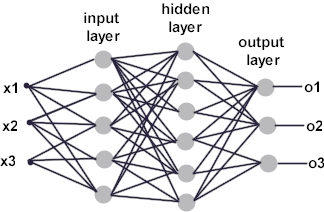

# Problem 

Sentiment analysis is the use of natural language processing (NLP) to determine the attitude expressed by an author in a piece of written text towards a topic, e.g. movie review. The attitude can be positive, neutral, and negative.
From a machine learning perspective, sentiment analysis can be treated as a classification problem. In the tutorial, we will train an MLP based model for sentiment analysis.
While there are other algorithms, such as Recursive Neural Network or Recurrent Neural Network, that are better at capturing the syntactic structure of the sentence for sentiment analysis, MLP is a straight and simple network that is quick to train.


# How to Use This Tutorial¶
You can use this tutorial by executing each snippet of python code in order as it appears in the notebook. An easy way to do so is to click on the "run cell, select below" arrow that is to the left of the "stop" icon in the toolbar. In this tutorial, we will train an MLP on an IMDB dataset which will ultimately produce a neural network that can predict the sentiment of movie reviews.


# Prerequisites
- Skills: Familiarity with MXNet, Python, Numpy, basics of MLP networks.
- Resource: An EC2 instance running the AWS Deep Learning AMI.

# Dataset Overview

The training and testing dataset is the IMDB movie review database.  It contains a total of 50,000 movie reviews that are tagged (labeled) with either a negative (0) or a positive (1) sentiment.  We will split the dataset into 25,000 reviews for training and 25,000 reviews for testing.

As you "play" each cell, watch for the "In[x]:" indication in the margin. When you see a star "*" character in-between square brackets, it means the cell is running. When it turns to a number, it means it has run.

# Load Modules

In [ ]:
# Load all the libraries and modules
import numpy as np
import sys
import os
import re

from text import Tokenizer
import mxnet as mx
from matplotlib import pyplot
from six.moves.urllib.request import urlopen
from sequence import pad_sequences

from IPython.display import display 
from ipywidgets import widgets

# Enable logging so we will see output during the training
import logging
logger = logging.getLogger()
logger.setLevel(logging.DEBUG)

# Process Movie Review Data

The raw reviews are in the aclImdb directory.  We will process the unzipped raw reviews into training and test datasets for training and validation purpose.

## LAB INSTRUCTION
- Enter **10000** as the value for the **vocabsize** variable.  This is the size of vocabulary for the encoding.  Any word outside of vacabulary will be encoded as 0.

In [ ]:
# We specify number of words to index and this is also the size of vocabulary
vocabsize =  10000  #Following instruction above

# This is the directory where the raw review data is located
path = "aclImdb/"

# List all the files for the reviews in the following directories
ff = [path + "train/pos/" + x for x in os.listdir(path + "train/pos")] + \
     [path + "train/neg/" + x for x in os.listdir(path + "train/neg")] + \
     [path + "test/pos/" + x for x in os.listdir(path + "test/pos")] + \
     [path + "test/neg/" + x for x in os.listdir(path + "test/neg")]


TAG_RE = re.compile(r'<[^>]+>')

def remove_tags(text):
    return TAG_RE.sub('', text)

input_label = ([1] * 12500 + [0] * 12500) * 2
input_text  = []

for f in ff:
    with open(f) as fin:
        pass
        input_text += [remove_tags(" ".join(fin.readlines()))]
            
# Initialize a tokenizer with the vocabulary size and train on data input text to create a vocabulary for all 
# the unique words found in the text inputs
tok = Tokenizer(vocabsize)
tok.fit_on_texts(input_text[:25000])
    
        
# Create the training and testing dataset.  Words will be replaced with indexes for the words        
X_train = tok.texts_to_sequences(input_text[:25000])
X_test  = tok.texts_to_sequences(input_text[25000:])
y_train = input_label[:25000]
y_test  = input_label[25000:]

# Data Summarization 

Let's take a look at some of the basic metrics of the datasets including the number of unique words, unique label values, and the mean and standard deviation of the data set.

## LAB INSTRUCTION:
- Anwer the following questions
   - What are the unique label values?
   - What is the mean size of all the review texts?

In [ ]:
# Let's do some analysis of the data

X = np.concatenate((X_train, X_test), axis=0)

# Summarize review length
print("Number of unique words : %i" % len(np.unique(np.hstack(X))))
print ('')
print ("Label value")
print (np.unique(y_train))
print ('')
print("Review length: ")

result = [len(x) for x in X]
print("Mean %.2f words (%f)" % (np.mean(result), np.std(result)))

# plot review length distribution
pyplot.boxplot(result)
pyplot.show()

# Additional Data Processing

We will pad the data to a fixed length and create NDArrayIter to be used for training later

## LAB INSTRUCTIONS
- Enter **500** as the value for the **maxtextlen** variable.
- Enter **250** as the value for the **Batch_Size** variable.
- Answer the questions below
    - Why do you think we want the maximum length to be 500?


In [ ]:
# Maximum text length for each review in the training data
maxtextlen = 500  #Follow instruction above
Batch_Size = 250  #Follow instruction above

# Specify the maximum length of the reviews we want to process and pad the training and test data 

X_train = pad_sequences(X_train, maxlen=maxtextlen)
X_test = pad_sequences(X_test, maxlen=maxtextlen)

# convert list to nd array type as mx.io.NDArrayIter takes nd array data type
y_train = np.asarray(y_train)
y_test = np.asarray(y_test)

# Create MXNet NDArray Iterators from the numpy training set and labels.  A batch size specified and the data will
# be shffled.  The iterators will be used as input to train and measure the model performance later.

trainIter = mx.io.NDArrayIter(X_train, y_train, Batch_Size, shuffle=True)
testIter = mx.io.NDArrayIter(X_test, y_test, Batch_Size, shuffle=True)

# Review Sample Input Data

## LAB INSTRUCTION
- Answer the following questions
    - What does each integer represent in the vector?
    - What is the length of the vector?

In [ ]:
# Let's also take a look at 1 row of the training data
# The integers represent a word in the original text 
print ('Review Example - Coded with word index')
print (X_train[0])

# Build an MLP Network

We will build a simple MLP network with 2 hidden layers, and a softmax classifier to determine the probability of negative and positive sentiment in the text.

In [ ]:
# create MLP network using MXNet Symbol API

# Create the input layer and place holder for the label
inputdata = mx.sym.Variable('data')
input_y = mx.sym.Variable('softmax_label')  # placeholder for label

# We embed the integer representation for each word into a vector of size 32.  Embedding is a technique that help 
# place related words close together. This helps improve the accuracy of model
# input_dim is the size of the vocabulary.  output_dim is the dimension of the output embedded vector.
Embeddata = mx.sym.Embedding(data = inputdata, input_dim=vocabsize, output_dim=32, name='embed') 

# The output from the embedding layer will be dimensional matrix, since MLP only accepts 1 dimensional vector, 
# we need to flatten it back to one dimension vector
data1 = mx.sym.Flatten(data = Embeddata, name='flatten')

# We create a fully connected layer with 250 neurons.  This layer will take the flattened input and 
# perform a linear calculation on the input data f(x) = ⟨w, x⟩ + b
fc1  = mx.sym.FullyConnected(data=data1, num_hidden=250)

# We add some nonlearity (Activation) into the network, so we can model non linear data patterns as not problem is linear problem
# Some of the common activations functions are 'relu', 'tanh', sigmoid.  
act1 = mx.sym.Activation(data=fc1, act_type="relu")  

# dropout layer
dropout=0.0

if dropout > 0.0:
    h_drop = mx.sym.Dropout(data=act1, p=dropout)
else:
    h_drop = act1

# We create anothe hidden layer with 2 hidden units as we have 2 desired output (1, 0)
fc2 = mx.sym.FullyConnected(data=h_drop, num_hidden=2) 

# Softmax is a classifier, and cross-entropy loss is used as the loss function by default.  
mlp = mx.sym.SoftmaxOutput(data=fc2, label=input_y, name='softmax')

# Now we have completed building the network, let's see what it looks like


## LAB INSTRUCTION

- Add a new cell by clicking on the **"+"** sign on the tool bar  
- Type **mx.viz.plot_network(mlp)** in the new cell and run the cell to visualize the network

# Model Training

Now we are ready to train the model.  We also need to define some hyper-parameters for model training.

## LAB INSTRUCTION
- Enter **10** as the value for variable **num_epoch**  - (This is number of epochs to train the model)
- Enter **mx.cpu()** or **mx.gpu()** (if gpu is available) as the value for variable **device**  - (This tells the program what cpu or gpu device to use)
- Enter **"adam"** as the value for variable **optimizer** - (This is the optimizer for updating the weights)
- Enter **"acc"** as the value for variable **eval_metric**  (This is the performance evaluation metric)


In [ ]:
# Set the number of epochs to run
num_epoch = 10     # Follow instruction above
device =  mx.cpu()  # Follow instruction above
optimizer =  "adam"     # Follow instruction above
eval_metric =  "acc"   # Follow instruction above

# Assign the network symbol(mlp) to the module class
mlp_model = mx.mod.Module(symbol=mlp, context=device) 


# Start training by calling the fit function
mlp_model.fit(trainIter,                      # training data               
    eval_data=testIter,                       # validation data                            
    optimizer= optimizer,                     # use adam optimizer to train
    optimizer_params={'learning_rate':0.01},  # set learning rate for adam         
    eval_metric= eval_metric,                 # report accuracy during training  
    batch_end_callback = mx.callback.Speedometer(Batch_Size, 100), # output progress for each 100 data batches   
    num_epoch=num_epoch) # train data passes indicatd by num_epoch
  


# Model Evaluation
We already evaluated the model during training.  Let's also try evaluating the trained model separately from the training step

In [ ]:
metric = mx.metric.Accuracy()
mlp_model.score(testIter, metric)

# Saving The Model

Now we have the model fully trained, we can save the model for later use.
2 files will be generated:
1. The json file captures the network configuration of the neural network
2. The params file captures the learned parameters for the network

## LAB INSTRUCTION
- After running the cell below, check the folder to see 2 new files are created

In [ ]:
# Save the model
prefix = "sentiment_mlp_"
mlp_model.save_checkpoint (prefix, num_epoch)

---
# Making Predictions


# Load Saved Model



In [ ]:
# Let's make some prediction using the saved model
# First load the model
prefix = "sentiment_mlp_"
model = mx.mod.Module.load(prefix, num_epoch, False)

# Now we need to bind the model with a datashape that represents the input, which will be 1xmaxtextlen
model.bind(for_training=False, data_shapes=[('data', (1,maxtextlen))])

In [ ]:
# Some helper function for making the prediction

# This function takes a text string and return a nd array with word indexes 
def prepare_imdb_list(text, maxlen=500, vocabsize=10000):
    imdb_word_index = tok.word_index
    
    sentence = []

    sentence.append(str(text))
    

    #tokenize the input sentence
    tokens = Tokenizer()
    tokens.fit_on_texts(sentence)

    # get a list of words from the encoding
    words = []
    for iter in range(len(tokens.word_index)):
        words += [key for key,value in tokens.word_index.items() if value==iter+1]
    
    # create a imdb based sequence from the words and specified vocab size
    imdb_seq = []
    err_count = 0
    for w in words:
        try:
            idx = imdb_word_index[w]
            if idx < vocabsize:
                imdb_seq.append(idx)
        except:
            err_count = err_count + 1

    # next we need to create a list of list so we can use pad_sequence to pad the inputs
    new_list = []
    new_list.append(imdb_seq)

    new_list = pad_sequences(new_list, maxlen=maxlen)
    
    return new_list


def predict_sentiment(model, text_nd):
    sentence_Iter = mx.io.NDArrayIter(text_nd, batch_size=1)
    pred = model.predict(sentence_Iter)

    return pred

def handle_submit(sender):
    text_nd = prepare_imdb_list(inputtext.value)
    pred = predict_sentiment(model, text_nd)
    outputlabel_0.value = 'Probability for negative sentiment (0):  %0.4f ' % pred.asnumpy()[0:1,0]
    outputlabel_1.value = 'Probability for positive sentiment (1):   %0.4f ' % pred.asnumpy()[0:1,1]

    

# Sample Movie Review Text For Testing

You can use the samples below - or any other review text - to try out the predictive power of the model. 

## Negative sentiment review samples
- Blake Edwards' legendary fiasco, begins to seem pointless after just 10 minutes. A combination of The Eagle Has Landed, Star!, Oh! What a Lovely War!, and Edwards' Pink Panther films, Darling Lili never engages the viewer; the aerial sequences, the musical numbers, the romance, the comedy, and the espionage are all ho hum. At what point is the viewer supposed to give a damn? This disaster wavers in tone, never decides what it wants to be, and apparently thinks it's a spoof, but it's pathetically and grindingly square. Old fashioned in the worst sense, audiences understandably stayed away in droves. It's awful. James Garner would have been a vast improvement over Hudson who is just cardboard, and he doesn't connect with Andrews and vice versa. And both Andrews and Hudson don't seem to have been let in on the joke and perform with a miscalculated earnestness. Blake Edwards' SOB isn't much more than OK, but it's the only good that ever came out of Darling Lili. The expensive and professional look of much of Darling Lili, only make what it's all lavished on even more difficult to bear. To quote Paramount chief Robert Evans, 24 million dollars worth of film and no picture.

- A mean spirited, repulsive horror film about 3 murderous children. Susan Strasberg is totally wasted in a 5-minute cameo, even though she receives star billing. If you are a Julie Brown fan, you'll want to check it out, since she's naked in a couple of shots. All others,avoid.


## Positive sentiment review samples
- I went and saw this movie last night after being coaxed to by a few friends of mine. I'll admit that I was reluctant to see it because from what I knew of Ashton Kutcher he was only able to do comedy. I was wrong. Kutcher played the character of Jake Fischer very well, and Kevin Costner played Ben Randall with such professionalism. The sign of a good movie is that it can toy with our emotions. This one did exactly that. The entire theater (which was sold out) was overcome by laughter during the first half of the movie, and were moved to tears during the second half. While exiting the theater I not only saw many women in tears, but many full grown men as well, trying desperately not to let anyone see them crying. This movie was great, and I suggest that you go see it before you judge.

- This is one of my three all-time favorite movies. My only quibble is that the director, Peter Yates, had too many cuts showing the actors individually instead of together as a scene, but the performances were so great I forgive him. Albert Finney and Tom are absolutely marvelous; brilliant. The script is great, giving a very good picture of life in the theatre during World War II (and, therefore, what it was like in the 30s as well). Lots of great, subtle touches, lots of broad, overplayed strokes, all of it perfectly done. Scene after scene just blows me away, and then there's the heartbreaking climax."



# Input Screen For Model Testing

Copy text into the text area and hit the 'Predict Sentiment' button to predict

In [ ]:
inputtext = widgets.Textarea()

display(inputtext)

inputbutton = widgets.Button(description='Predict Sentiment')

display(inputbutton)

outputlabel_0 = widgets.HTML()
outputlabel_1 = widgets.HTML()
display(outputlabel_0)
display(outputlabel_1)

inputbutton.on_click(handle_submit)